In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn import tree

from model import create_model
from fitting import oversample, undersample

In [13]:
data_file_name = "./files/fertility_Diagnosis.csv"

data_columns = [
    'Season',
    'Age',
    'Childish diseases',
    'Accidents or serious trauma',
    'Surgical intervention',
    'High fevers in the last year',
    'Frequency of alcohol consumption',
    'Smoking habit',
    'Number of hours spent sitting per day',
    'Output'
]

In [14]:
# columns used for prediction
columns_x = [
    'Season',
    'Age',
    'Childish diseases',
    'Accidents or serious trauma',
    'Surgical intervention',
    'High fevers in the last year',
    'Frequency of alcohol consumption',
    'Smoking habit',
    'Number of hours spent sitting per day'
]

# remove fatures - Season, CD, Fev
columns_x_graph = [
    'Season',
    'Age',
    'CD',
    'Accid',
    'Surg',
    'Fev',
    'Alc',
    'Smok',
    'Sitt'
]

# columns that are predicted
columns_y = [
    'Output'
]

In [15]:
# random-state, used as seed value for other libraries, so that we always get the same result
RS = 1
# number of splits during cross-validation
NUM_SPLITS = 5

plot_decision_tree=True
# use_PCA=False

In [16]:
# read data from csv file
df = pd.read_csv(data_file_name)

# get numpy representation of training data
data_X = df[columns_x].values
data_Y = df[columns_y].values

In [17]:
X = data_X
Y = data_Y

In [30]:
if plot_decision_tree:
    tree_model = create_model(model_name='decision-tree', num_iter=100, class_weight={}, random_state=RS)
    tree_model.fit(X, Y)
    tree.plot_tree(decision_tree=tree_model, feature_names=columns_x_graph, class_names=['N', 'O'], filled=True, fontsize=3)


TypeError: create_model() got an unexpected keyword argument 'random_state'

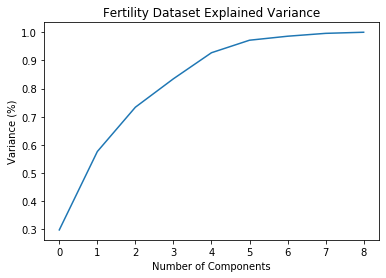

In [22]:
pca = PCA(
    # n_components=7,
    random_state=RS)
pca.fit(X)

#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Fertility Dataset Explained Variance')
plt.show()


In [24]:
sample = 'oversample'
DN = df.loc[df.Output == 'N']
DO = df.loc[df.Output == 'O']
if sample == 'undersample':
    D = undersample(DN, DO)
    X = D[columns_x].values
    Y = D[columns_y].values
elif sample == 'oversample':
    D = oversample(DN, DO)
    X = D[columns_x].values
    Y = D[columns_y].values

# class weights to fix imbalanced classes
class_weights = {
    'N': 1,
    'O': 1
}



In [25]:
use_PCA = False
if use_PCA:
    X = pca.fit_transform(X)
else:
    X = data_X

In [26]:
# create cross-validation
kf = KFold(n_splits=NUM_SPLITS, shuffle=True, random_state=RS)

In [29]:
# iterate over cross-validation sets
# train_index - indices of records used for training at current iteration over cross-validation sets
# test_index - indices of records used for testing at current iteration over cross-validation sets

for train_index, test_index in kf.split(X, Y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    # create and train model
    model = create_model(
        'random-forest',
        300,
        class_weights,
        RS,
    ).fit(X_train, np.reshape(y_train, (y_train.shape[0])))

    # get model score on test set
    score = model.score(X_test, y_test)
    # get model score on whole data-set
    score_ds = model.score(X, Y)

    # test model on members of class 'O'
    df_test = df.loc[df.Output == 'O']
    if use_PCA:
        predictions = model.predict(pca.transform(df_test[columns_x].values))
    else:
        predictions = model.predict(df_test[columns_x].values)

    # print results
    print('Test score: ', score)
    print('Whole data-set score: ', score_ds)
    print(predictions)

ValueError: Found input variables with inconsistent numbers of samples: [100, 176]